In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 256
import shutil
import os
import numpy as np
import torch
from torch import nn, optim, autograd
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.utils as vutils
import torch.utils.data as udata
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
from IPython.display import HTML

In [2]:
class EqualLR:
    def __init__(self, name):
        self.name = name
    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()
        return weight * np.sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)
        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)
        return fn
    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)
    return module


class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)
        
    def forward(self, input):
        return self.conv(input)

In [3]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel1, pad1, kernel2, pad2, pixel_norm=True):
        super().__init__()
        
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.stride1 = 1
        self.stride2 = 1
        self.pad1 = pad1
        self.pad2 = pad2
        
        if pixel_norm:
            self.conv = nn.Sequential(EqualConv2d(in_channel, out_channel, self.kernel1, self.stride1, self.pad1),
                                      PixelNorm(),
                                      nn.LeakyReLU(0.2),
                                      EqualConv2d(out_channel, out_channel, self.kernel2, self.stride2, self.pad2),
                                      PixelNorm(),
                                      nn.LeakyReLU(0.2))
        else:
            self.conv = nn.Sequential(EqualConv2d(in_channel, out_channel, self.kernel1, self.stride1, self.pad1),
                                      nn.LeakyReLU(0.2),
                                      EqualConv2d(out_channel, out_channel, self.kernel2, self.stride2, self.pad2),
                                      nn.LeakyReLU(0.2))
    def forward(self, input):
        out = self.conv(input)
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self, code_dim=512):
        super().__init__()
        self.code_norm = PixelNorm()
        self.progression = nn.ModuleList([ConvBlock(512, 512, 4, 3, 3, 1),
                                          ConvBlock(512, 512, 3, 1, 3, 1),
                                          ConvBlock(512, 512, 3, 1, 3, 1),
                                          ConvBlock(512, 512, 3, 1, 3, 1),
                                          ConvBlock(512, 256, 3, 1, 3, 1),
                                          ConvBlock(256, 128, 3, 1, 3, 1)])
        self.to_rgb = nn.ModuleList([nn.Conv2d(512, 3, 1),
                                     nn.Conv2d(512, 3, 1),
                                     nn.Conv2d(512, 3, 1),
                                     nn.Conv2d(512, 3, 1),
                                     nn.Conv2d(256, 3, 1),
                                     nn.Conv2d(128, 3, 1),])
        
    def forward(self, input, expand=0, alpha=-1):
        out = self.code_norm(input)
        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):
            if i > 0 and expand > 0:
                upsample = F.interpolate(out, scale_factor=2)
                out = conv(upsample)
            else:
                out = conv(out)
                
            if i == expand:
                out = to_rgb(out)
                
                if i > 0 and 0 <= alpha < 1:
                    skip_rgb = self.to_rgb[i - 1](upsample)
                    out = (1 - alpha) * skip_rgb + alpha * out
                break
            
        return out

In [6]:
class Distriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.progression = nn.ModuleList([ConvBlock(128, 256, 3, 1, 3, 1, pixel_norm=False),
                                          ConvBlock(256, 512, 3, 1, 3, 1, pixel_norm=False),
                                          ConvBlock(512, 512, 3, 1, 3, 1, pixel_norm=False),
                                          ConvBlock(512, 512, 3, 1, 3, 1, pixel_norm=False),
                                          ConvBlock(512, 512, 3, 1, 3, 1, pixel_norm=False),
                                          ConvBlock(513, 512, 3, 1, 4, 0, pixel_norm=False),])
        self.from_rgb = nn.ModuleList([nn.Conv2d(3, 128, 1),
                                       nn.Conv2d(3, 256, 1),
                                       nn.Conv2d(3, 512, 1),
                                       nn.Conv2d(3, 512, 1),
                                       nn.Conv2d(3, 512, 1),
                                       nn.Conv2d(3, 512, 1),])
        self.n_layer = len(self.progression)
        self.linear = nn.Linear(512, 1)
    
    def forward(self, input, expand=0, alpha=-1):
        for i in range(expand, -1, -1):
            index = self.n_layer - i - 1
            if i == expand:
                out = self.from_rgb[index](input)
            if i == 0:
                mean_std = input.std(0).mean()
                mean_std = mean_std.expand(input.size(0), 1, 4, 4)
                out = torch.cat([out, mean_std], 1)
            out = self.progression[index](out)
            
            if i > 0:
                out = F.avg_pool2d(out, 2)
                if i == expand and 0 <= alpha < 1:
                    skip_rgb = F.avg_pool2d(input, 2)
                    skip_rgb = self.from_rgb[index + 1](skip_rgb)
                    out = (1 - alpha) * skip_rgb + alpha * out
                    
        out = out.squeeze(2).squeeze(2)
        out = self.linear(out)
        return out

In [7]:
dataroot = '/home/samael/github/image_generation/dcgan/'
workers = 8
# batch size map {4:32, 8:32, 16:32, 32:16, 64:16, 128:16, 256:12, 512:3, 1024:1}
batch_size = 32
image_size = 4
nc = 3
nz = 512
num_epochs = 300
ngpu = 2
device = torch.device('cuda:0')

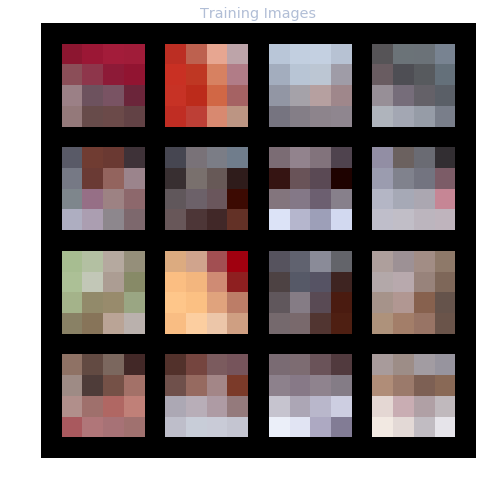

In [8]:
def modify_data(root, image_size):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = vdatasets.ImageFolder(root=root, transform=transform)
    return dataset

dataset = modify_data(dataroot, image_size)

dataloader = udata.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=1, normalize=True, nrow=4).cpu(),(1,2,0)))
plt.show()

In [9]:
netG = Generator(nz).to(device)
netD = Distriminator().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

In [10]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
criterion = nn.BCEWithLogitsLoss()
real_label = 1
fake_label = 0
lr = 0.001
beta1 = 0.0
g_optimizer = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.99))
d_optimizer = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.99))

In [11]:
experiment_path = 'checkpoint/pggan'
img_list = []
G_losses = []
D_losses = []
D_losses_tmp = []
Grad_penalty = []
i = 0
iters = 0
total_iters = 0
expand = 0
n_critic = 1
step = 0
alpha = 0
CLAMP = 0.01
one = torch.FloatTensor([1]).cuda()
mone = one * -1
print('Training start!')
for epoch in range(num_epochs):
    if epoch != 0 and epoch % 50 == 0:
        alpha = 0
        iters = 0
        expand += 1
        if expand >= 3:
            batch_size = 16
        if expand > 5:
            alpha = 1
            expand = 5
        dataset = modify_data(dataroot, image_size * 2 ** expand)
        dataloader = udata.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    for i, data in enumerate(dataloader):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        if step < n_critic:
            netD.zero_grad()
            for p in netD.parameters():
                p.requires_grad = True
#                 p.data.clamp_(-CLAMP, CLAMP)
            output = netD(real_cpu, expand, alpha).view(-1)
            errD_real = (output.mean() - 0.001 * (output ** 2).mean()).view(1)
            errD_real.backward(mone)
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise, expand, alpha)
            output = netD(fake.detach(), expand, alpha).view(-1)
            errD_fake = output.mean().view(1)
            errD_fake.backward(one)
            eps = torch.rand(b_size, 1, 1, 1, device=device)
            x_hat = eps * real_cpu.data + (1 - eps) * fake.data
            x_hat.requires_grad = True
            hat_predict = netD(x_hat, expand, alpha)
            grad_x_hat = autograd.grad(outputs=hat_predict.sum(), inputs=x_hat, create_graph=True)[0]
            grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()
            grad_penalty = 10 * grad_penalty
            grad_penalty.backward()
            errD = errD_real - errD_fake
            d_optimizer.step()
            D_losses_tmp.append(errD.item())
            step += 1
        else:
            for p in netD.parameters():
                p.requires_grad = False
            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise, expand, alpha)
            output = netD(fake, expand, alpha).view(-1)
            errG = -output.mean().view(1)
            errG.backward()
            g_optimizer.step()
            D_losses.append(np.mean(D_losses_tmp))
            G_losses.append(errG.item())
            D_losses_tmp = []
            step = 0
        if (total_iters+1) % 200 == 0:
            print('[%d/%d][%d/%d](%d)\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f\tGrad: %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloader), total_iters + 1,
                     errD.item(), errG.item(), errD_real.data.mean(), errD_fake.data.mean(), grad_penalty.data))
        # Check how the generator is doing by saving G's output on fixed_noise
        if (total_iters % 5000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, expand, alpha).detach().cpu()
            img = vutils.make_grid(fake, padding=2, normalize=True)
            vutils.save_image(img, 'checkpoint/pggan/fake_image/fake_iter_{0}.jpg'.format(total_iters))
            img_list.append(img)

        iters += 1
        total_iters += 1
        if (epoch + 1) % 50 == 0:
            torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment_path, epoch+1))
            torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment_path, epoch+1))

Training start!
[1/300][200/2188](200)	Loss_D: 0.1856	Loss_G: 0.4442	D(x): -0.1759	D(G(z)): -0.3616	Grad: 0.0577
[1/300][400/2188](400)	Loss_D: 1.3271	Loss_G: 2.6819	D(x): -0.4560	D(G(z)): -1.7831	Grad: 0.2399
[1/300][600/2188](600)	Loss_D: 0.2456	Loss_G: 0.3145	D(x): 0.1867	D(G(z)): -0.0589	Grad: 0.0624
[1/300][800/2188](800)	Loss_D: 0.3652	Loss_G: 0.1997	D(x): -0.0211	D(G(z)): -0.3864	Grad: 0.0897
[1/300][1000/2188](1000)	Loss_D: 0.2306	Loss_G: 0.5143	D(x): 0.0869	D(G(z)): -0.1437	Grad: 0.0219
[1/300][1200/2188](1200)	Loss_D: 0.1224	Loss_G: 0.4189	D(x): -0.1651	D(G(z)): -0.2874	Grad: 0.1801
[1/300][1400/2188](1400)	Loss_D: 0.2481	Loss_G: 0.1582	D(x): 0.0419	D(G(z)): -0.2063	Grad: 0.0261
[1/300][1600/2188](1600)	Loss_D: 0.3606	Loss_G: 0.4014	D(x): -0.0774	D(G(z)): -0.4381	Grad: 0.0909
[1/300][1800/2188](1800)	Loss_D: 0.1140	Loss_G: 0.2680	D(x): -0.1480	D(G(z)): -0.2619	Grad: 0.1155
[1/300][2000/2188](2000)	Loss_D: 0.3516	Loss_G: 0.2222	D(x): 0.1549	D(G(z)): -0.1967	Grad: 0.1631
[2/300

Process Process-31:
Process Process-32:
Process Process-30:
Process Process-28:
Process Process-26:
Process Process-25:
Process Process-27:
Process Process-29:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/samael/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/samael/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/samael/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/samael/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/samael/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/samael/anaconda3/lib/python3.6/multiprocessing/proc

  File "/home/samael/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 161, in pil_loader
    return img.convert('RGB')
  File "/home/samael/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 132, in __getitem__
    sample = self.loader(path)
  File "/home/samael/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 899, in convert
    self.load()
KeyboardInterrupt
  File "/home/samael/anaconda3/lib/python3.6/site-packages/PIL/ImageFile.py", line 239, in load
    n, err_code = decoder.decode(b)
  File "/home/samael/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 899, in convert
    self.load()
  File "/home/samael/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 178, in default_loader
    return pil_loader(path)
  File "/home/samael/anaconda3/lib/python3.6/site-packages/PIL/JpegImagePlugin.py", line 362, in load_read
    s = self.fp.read(read_bytes)
  File "/home/samael/anaconda3/lib/python3.6/s

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())